# DummyClassifier 

We want to show performance improvement and establish a baseline. Our strategy is:

Dummy → Logistic → RandomForest → LGBM

This notebook focuses on DummyClassifier

In [1]:
# Import packages
from xgboost import XGBClassifier

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

RSEED=42

In [2]:
# Load cleaned training data
train_df = pd.read_pickle('data/train_cleaned.pkl')

In [3]:
#shape of the training data
train_df.shape

(595212, 35)

In [ ]:
#define X and y
X = train_df.drop(columns=['target'])
y = train_df['target']

# Check for NaN values before imputation
print(f"Missing values before imputation: {X.isnull().sum().sum()}")

# Handle missing values - fill with median for numeric columns
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X = X_imputed

print(f"Missing values after imputation: {X.isnull().sum().sum()}")

#split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [31]:
#fit the dummy model
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
print("AUC:", roc_auc_score(y_valid, dummy.predict_proba(X_valid)[:,1]))


AUC: 0.5


This is an expected result. It shows no discrimination and how well you'd do blind guessing.

Let's visualize this with an ROC Curve. This should show as a perfect 45° diagonal from (0,0) to (1,1). Meaning this model can't tell claims from non-claims so you're gaining true positives at the same rate as false positives. It should be a blind model.

Text(0, 0.5, 'True Positive Rate')

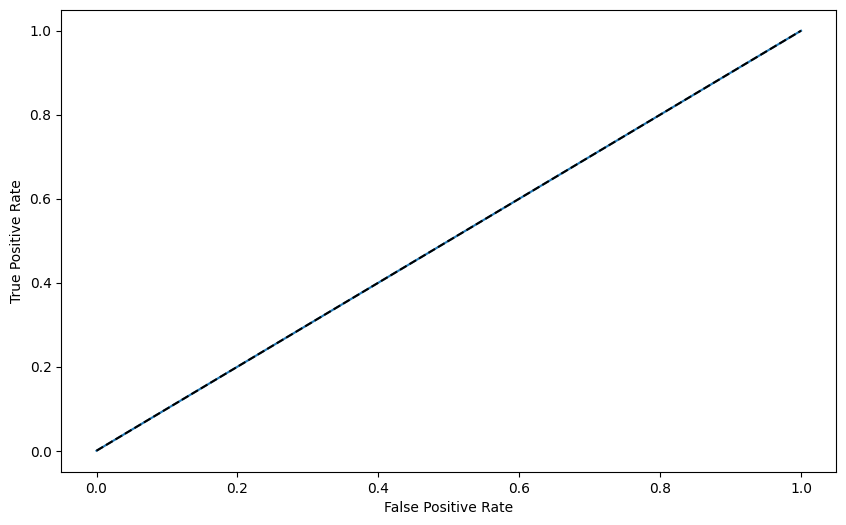

In [32]:
#plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, dummy.predict_proba(X_valid)[:,1])
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Perfect, looks exactly like we expect from a DummyClassifier model. Now we have a baseline that we can later layer with results from our other models.

Let's look at the confusion matrix
Since we used the strategy = "most frequent" we should see that True Negatives have the largest values because the model always predicts the majority class (No Claim).

Text(95.72222222222221, 0.5, 'Actual')

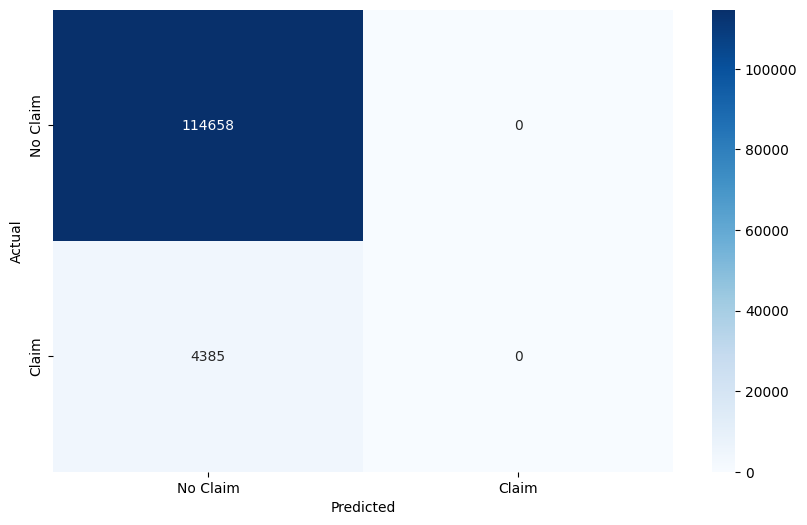

In [33]:
#plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, dummy.predict(X_valid))
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Claim', 'Claim'], yticklabels=['No Claim', 'Claim'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

This is showing as expected as well.
- 114,658 as no claim
- 4,385 as false negatives (missed claims?)

But, the model doesn't have any claims? weird. Imbalanced data?

Now let's take a look at the precision recall curve. The should slop the opposite direction of our ROC curve.

Text(0.5, 0, 'Recall')

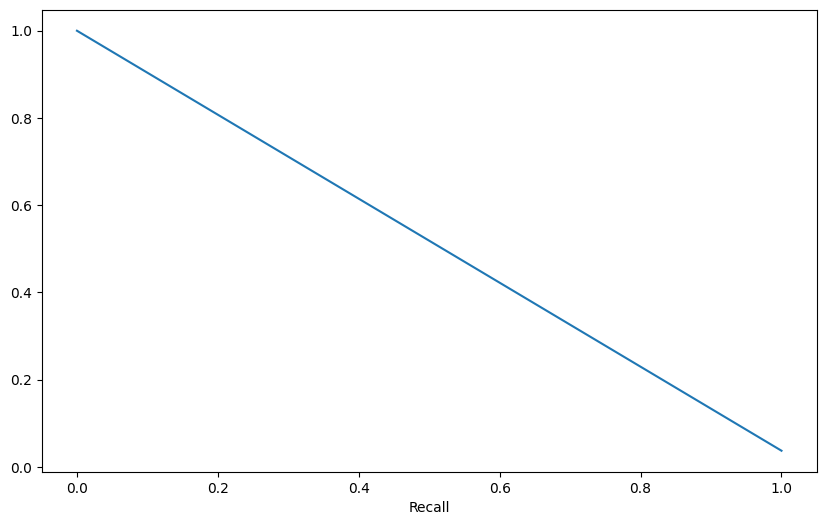

In [38]:
#plot the precision recall curve
precision, recall, thresholds = precision_recall_curve(y_valid, dummy.predict_proba(X_valid)[:,1])
plt.figure(figsize=(10,6))
plt.plot(recall, precision)
plt.xlabel('Recall')

We are getting what we expect. 

Let's look at a final visual with the predicted probability histogram.

We should see a solid bar at 0 because the DummyClassifier is predicting only 0s (No Claim).

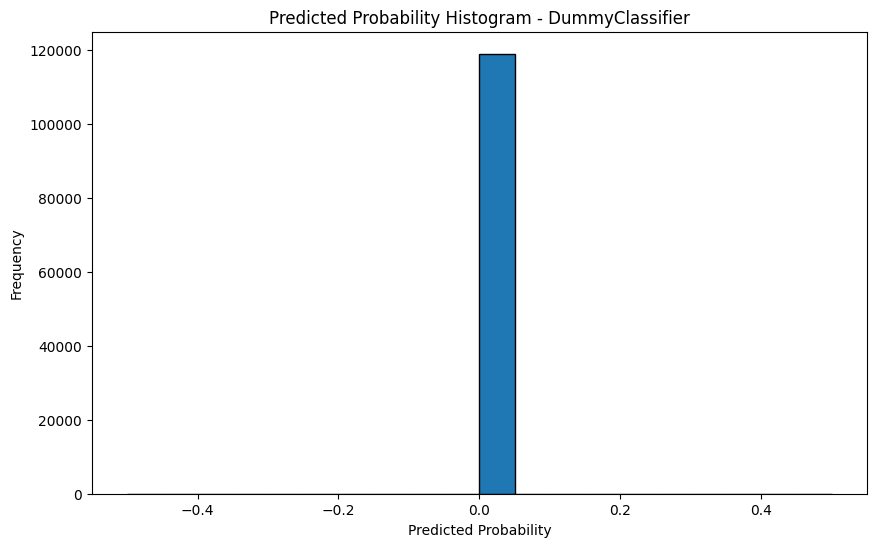

In [39]:
#plot the predicted probability histogram
plt.figure(figsize=(10,6))
plt.hist(dummy.predict_proba(X_valid)[:,1], bins=20, edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Predicted Probability Histogram - DummyClassifier')
plt.show()